In [1]:
# Imports
from evaluation import *
from utils import * 
import time
from skimage import io, color

In [2]:
# Load in codebook and get our respective submatrix
id_sub = identifiable_submatrices('codebook.csv')
matrix = id_sub.clean_matrices[(0, 1, 3, 2, 4, 5)][0]
print("Our submatrix of interest:\n", matrix[0])
rows = [id_sub.idx_to_row[i] for i in (0, 1, 3, 2, 4, 5)]
print("Rows being: ", rows)
columns = [id_sub.idx_to_col[i] for i in matrix[1]]
print("Columns being: ", columns)
matrix_test = matrix[0][:3]
print("\n Our test matrix:\n", matrix_test)
matrix_identity = matrix[0][3:]
print("\n Our identity matrix:\n", matrix_identity)

5040 number of combinations of row orderings
10368 number of possible submatrices
Our submatrix of interest:
 [[1. 0. 1. 1.]
 [1. 1. 0. 1.]
 [0. 1. 1. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
Rows being:  ['NWS', 'VSVG', 'HSV', 'FLAG', 'C', 'S']
Columns being:  ['A2', 'E8', 'D11', 'F8']

 Our test matrix:
 [[1. 0. 1. 1.]
 [1. 1. 0. 1.]
 [0. 1. 1. 1.]]

 Our identity matrix:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


In [3]:
# List of files:
title = ["F030", "F031", "F032", "F039", "F040", "F041", "F049", "F050", "F051"]
# Load in image
image = load_tif(f'data/{title[3]}_trim_manual.tif')

In [4]:
def calculate_metrics(i_matrix, test_matrix):
    # assuming its in [Channel, Height, Width] shape
    for i in range(4):
        i_mat = i_matrix[i]
        t_mat = test_matrix[i]
        print(i_mat.shape, t_mat.shape)
        print("Genotype: ", columns[i])
        num_pixels_i = np.sum(i_mat > 0)
        print(f'total number of pixels above 0 in identity: {num_pixels_i}')
        num_pixels_test = np.sum(t_mat > 0)
        print(f'total number of pixels above 0 in test: {num_pixels_test}')
        otsu_i = i_mat > threshold_otsu(i_mat)
        sum_otsu_i = np.sum(otsu_i)
        print(f'percentage of pixels above otsu threshold in identity {sum_otsu_i / num_pixels_i}')
        otsu_test = t_mat > threshold_otsu(t_mat)
        sum_otsu_t = np.sum(otsu_test)
        print(f'percentage of pixels above otsu threshold in test {sum_otsu_t / num_pixels_test}')

        print("Elementwise Accuracy with Deviation: ", elementwise_accuracy(t_mat, i_mat, ignore_zeros=True, deviation=0.1))
        print("Mean Squared Error: ", mse(i_mat, t_mat))
        print("Structural Similarity Index: ", ssim_err(i_mat, t_mat))
        print("\n")

## Original Test Image

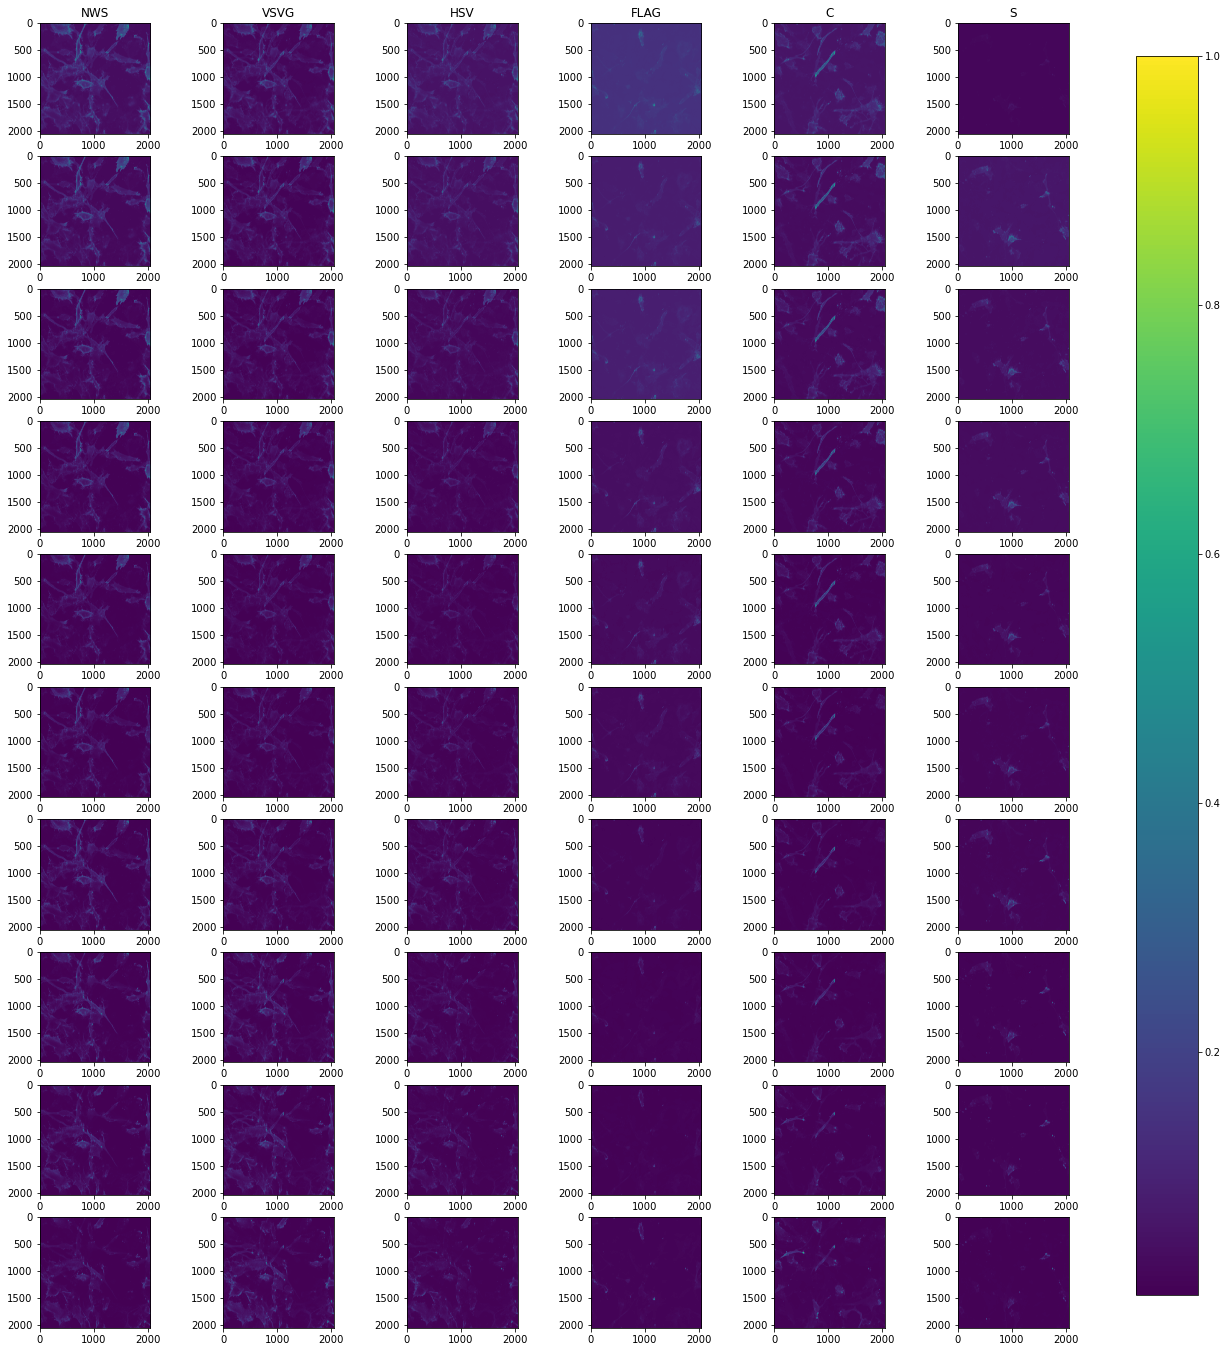

In [5]:
fig, axs = plt.subplots(10,6, figsize=(24,24))
for idx in range(10):
    img = image[idx]
    img[[2,3],:] = img[[3,2],:]
    for i in range(6):
        im = axs[idx, i].imshow(img[i], cmap = 'viridis')
for ax,col in zip(axs[0], rows):
    ax.set_title(col)
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.95)
plt.savefig('line_in_image.jpg')
plt.show()

In [6]:
# Pick a slice to use for our example
img = image[4]
print("Shape of image: ", img.shape)
# Split img into test image and identity part of image
img_test = img[:3]
print("Shape of our test image:", img_test.shape)
img_identity = img[3:]
print("Shape of our identity image:", img_identity.shape) 

Shape of image:  (6, 2048, 2048)
Shape of our test image: (3, 2048, 2048)
Shape of our identity image: (3, 2048, 2048)


## Our Slice of Interest

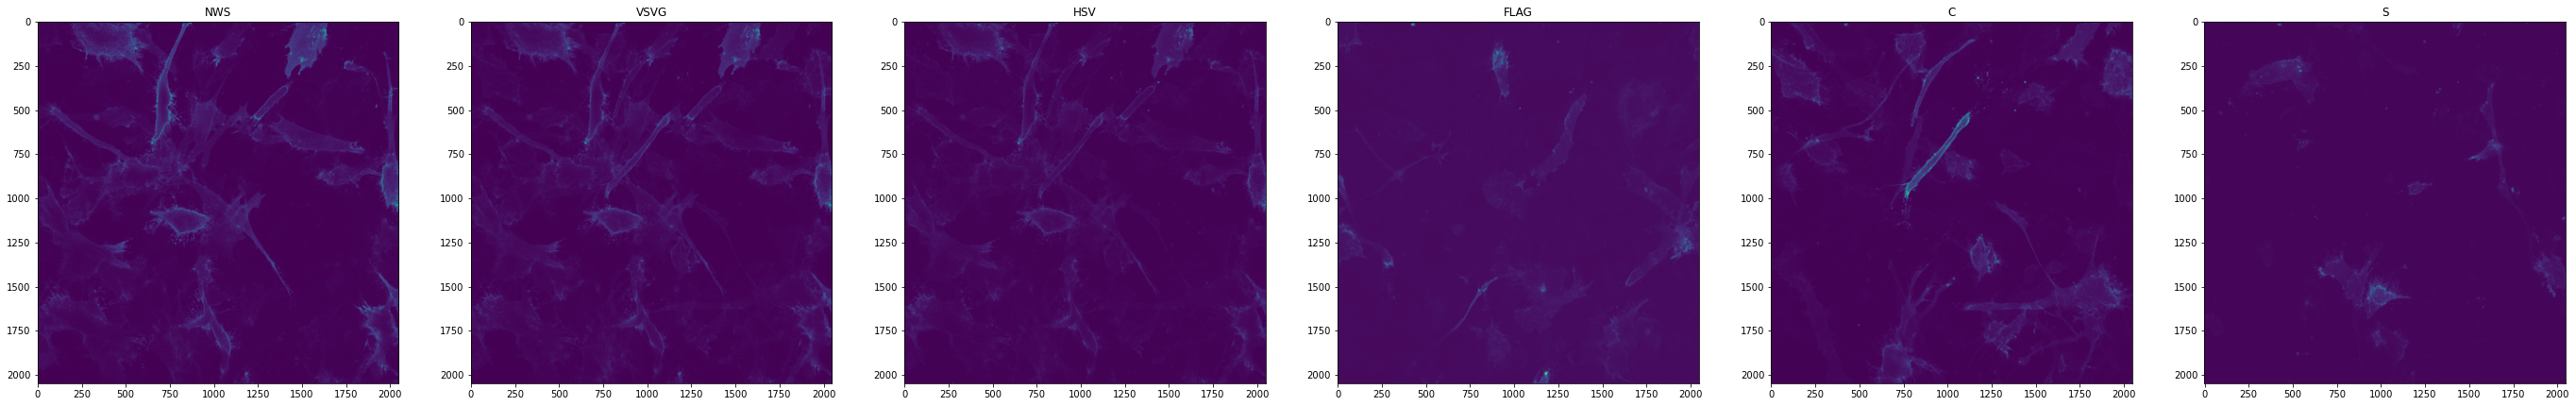

Corresponding Matrix: 
 [[1. 0. 1. 1.]
 [1. 1. 0. 1.]
 [0. 1. 1. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


In [10]:
fig, axs = plt.subplots(1,6, figsize=(48,24))
for i in range(6):
    im = axs[i].imshow(img[i], cmap = 'viridis')
for ax,col in zip(axs, rows):
    ax.set_title(col)
plt.show()
print("Corresponding Matrix: \n", matrix[0])

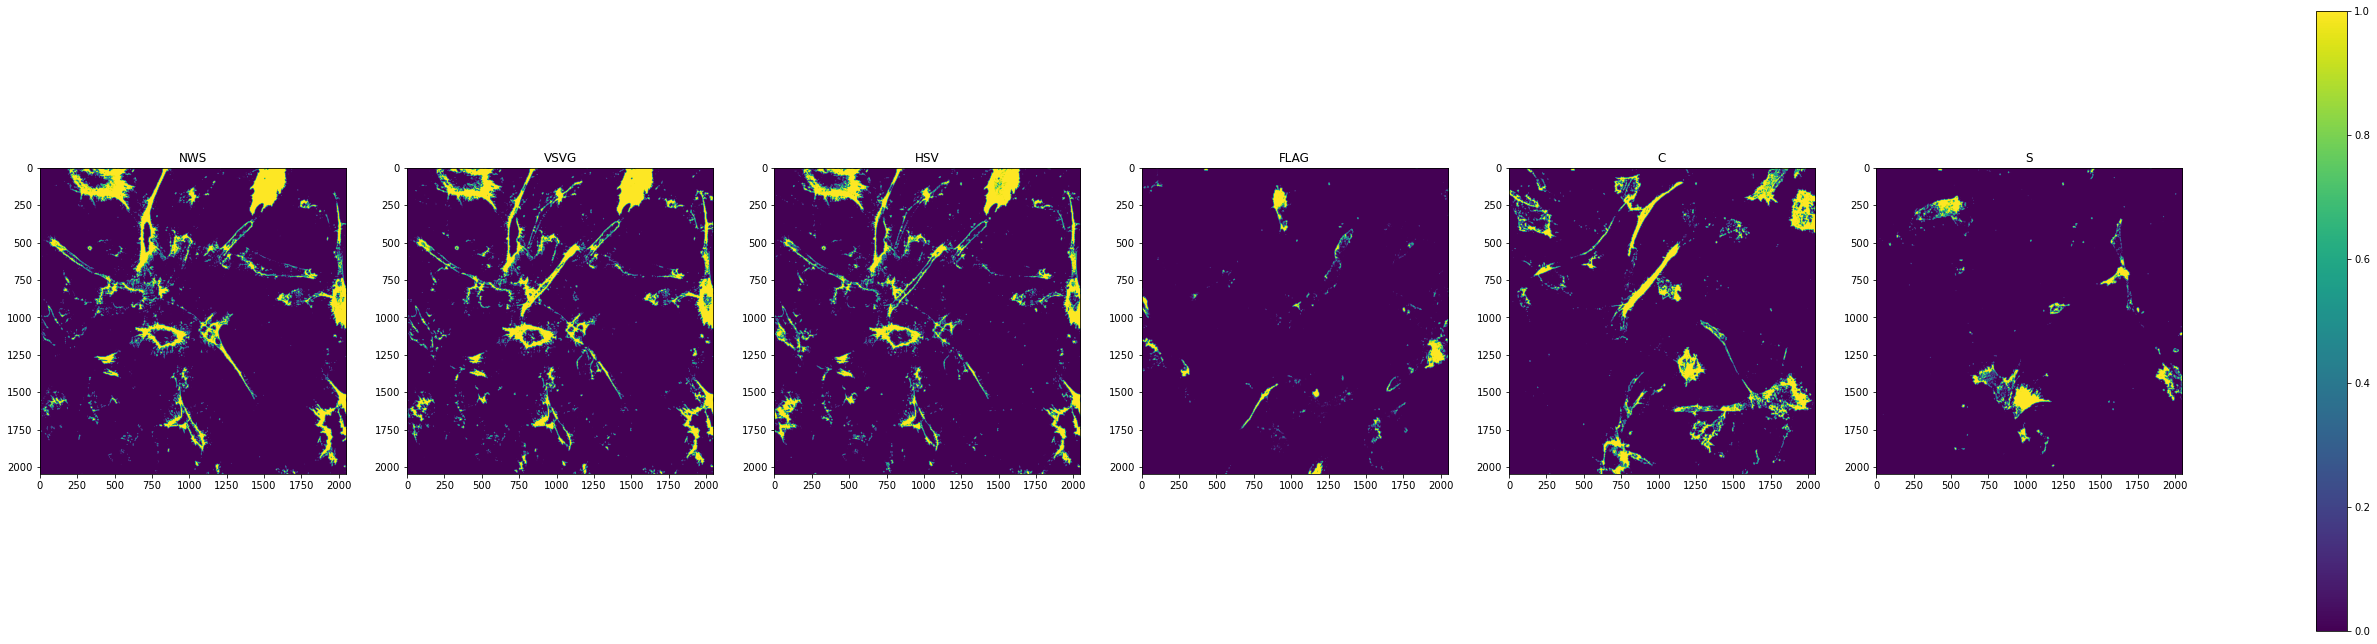

Corresponding Matrix: 
 [[1. 0. 1. 1.]
 [1. 1. 0. 1.]
 [0. 1. 1. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


In [8]:
img_thr = []
for img_i in img:
    img_i_c = np.copy(img_i)
    img_i_c = img_i_c > threshold_otsu(img_i_c)
    img_thr.append(img_i_c)
    
fig, axs = plt.subplots(1,6, figsize=(48,12))
for i in range(6):
    im = axs[i].imshow(img_thr[i],  cmap = 'viridis')
for ax,col in zip(axs, rows):
    ax.set_title(col)
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.95)
plt.show()
print("Corresponding Matrix: \n", matrix[0])

# Testing With Otsu On z_test *after* deconvolution

In [9]:
# Now we perform matching pursuit
print(matrix_test)
z_test = matching_pursuit(img_test, matrix_test.T, max_iters=4)
print("z_test shape:", z_test.shape)
z_identity = np.concatenate([img_identity, np.array([img_test.sum(0) - 2*img_identity.sum(0)])], axis=0)
print("z_identity shape:", z_identity.shape) 

[[1. 0. 1. 1.]
 [1. 1. 0. 1.]
 [0. 1. 1. 1.]]
[[1. 1. 0.]
 [0. 1. 1.]
 [1. 0. 1.]
 [1. 1. 1.]]
[[0.70710678 0.70710678 0.        ]
 [0.         0.70710678 0.70710678]
 [0.70710678 0.         0.70710678]
 [0.57735027 0.57735027 0.57735027]]
(4, 3) (3, 2048, 2048)
z_test shape: (4, 2048, 2048)
z_identity shape: (4, 2048, 2048)


In [10]:
# thrs = np.array([threshold_otsu(z_i) for z_i in z])
# img_thr[j] = img[j] > threshold_otsu(img[j])

for i in range(z_test.shape[0]):
    z_test[i] = z_test[i] > threshold_otsu(z_test[i])
    z_identity[i] = z_identity[i] > threshold_otsu(z_identity[i])

## Test After Deconvolution

C:\Users\vinhl\AppData\Local\Temp\ipykernel_17528\1955868420.py:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("tab20").copy()
  cm.set_bad('k')


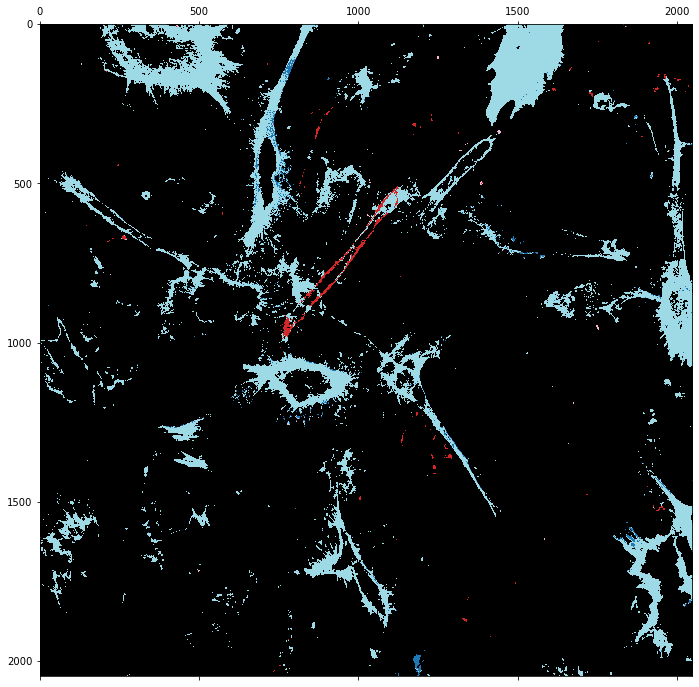

In [11]:
cm = plt.get_cmap('tab20')
cm.set_bad('k')
fig = plt.figure(figsize=(12,12))
ax = plt.gca().matshow(np.where(z_test.max(0)==0,np.nan,z_test.argmax(0)),cmap=cm)

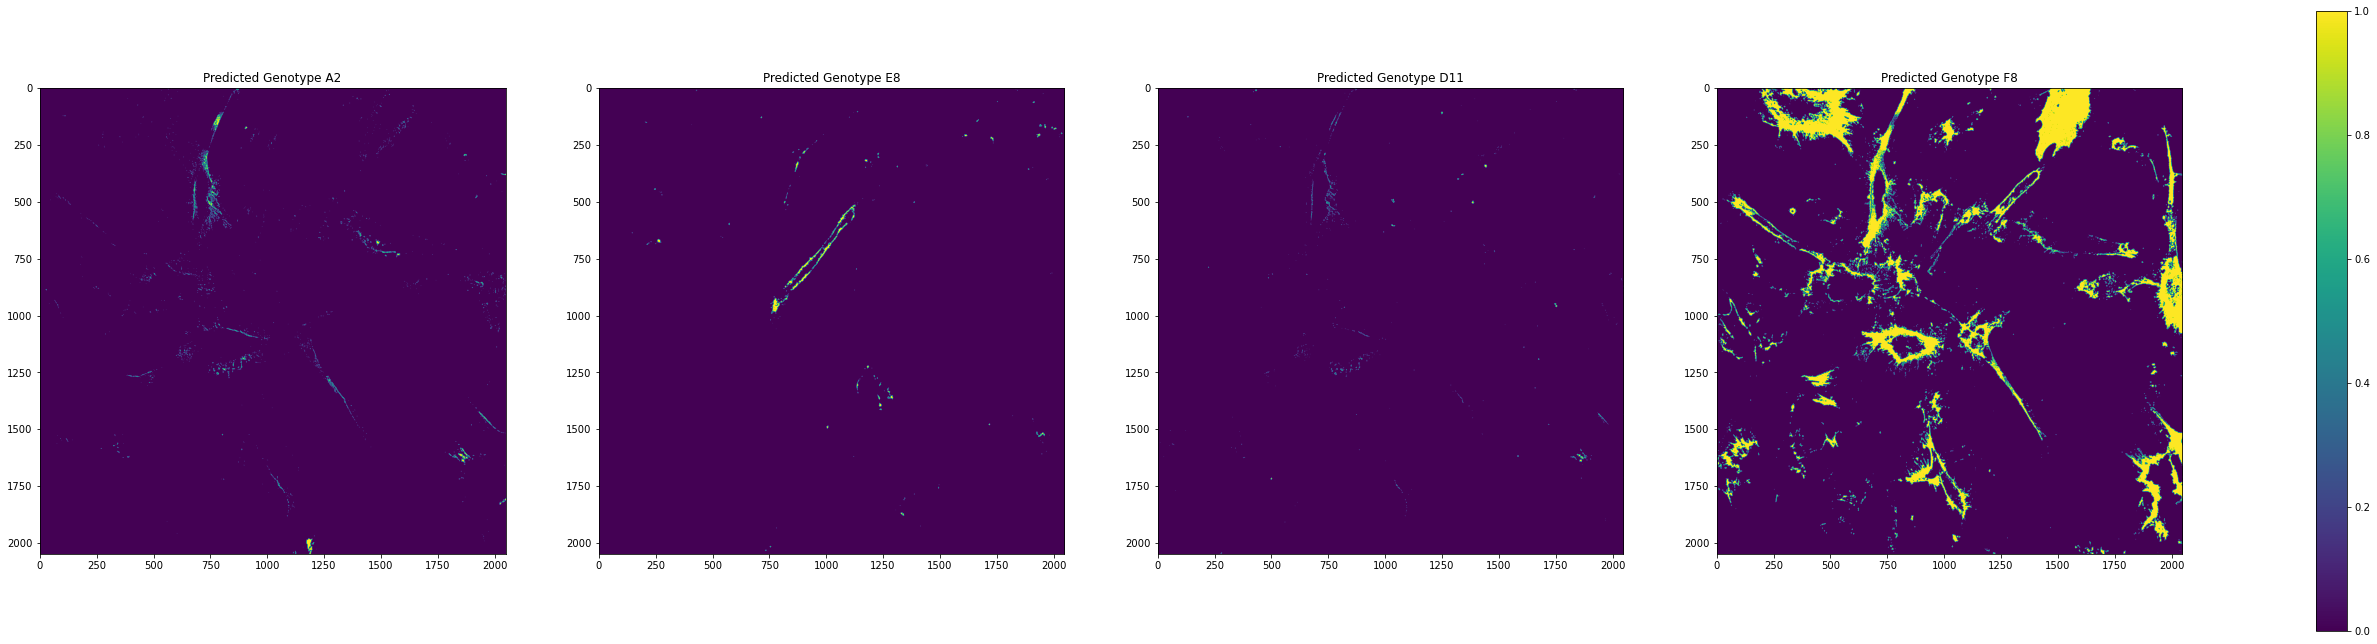

Matrix Test:
 [[1. 0. 1. 1.]
 [1. 1. 0. 1.]
 [0. 1. 1. 1.]]


In [12]:
fig, axs = plt.subplots(1,4, figsize=(48,12))
for idx in range(z_test.shape[0]):
    im = axs[idx].imshow(z_test[idx],  cmap = 'viridis')
for ax, col in zip(axs, columns):
    ax.set_title(f'Predicted Genotype {col}')
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.95)

plt.show()
print("Matrix Test:\n", matrix_test)

## Identity After Concat

C:\Users\vinhl\AppData\Local\Temp\ipykernel_17528\1283809606.py:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("tab20").copy()
  cm.set_bad('k')


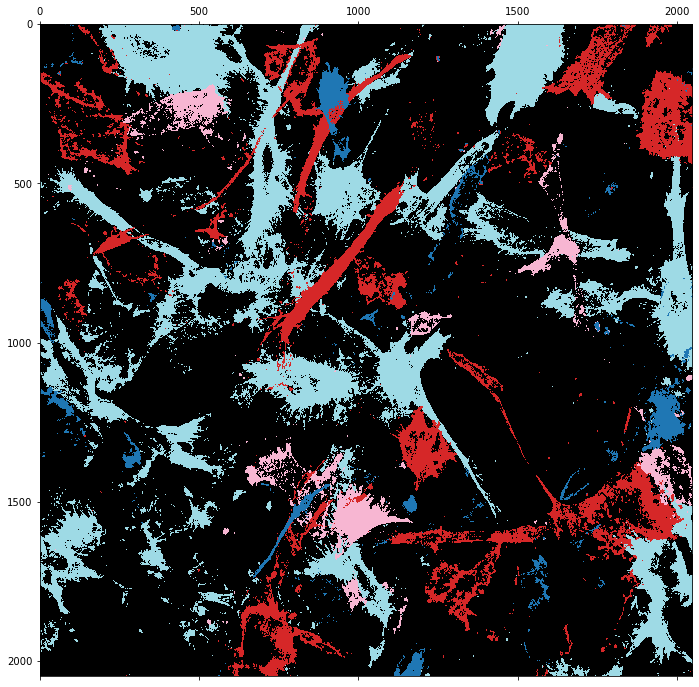

In [13]:
cm = plt.get_cmap('tab20')
cm.set_bad('k')
plt.figure(figsize=(12,12))
plt.gca().matshow(np.where(z_identity.max(0)==0,np.nan,z_identity.argmax(0)),cmap=cm)

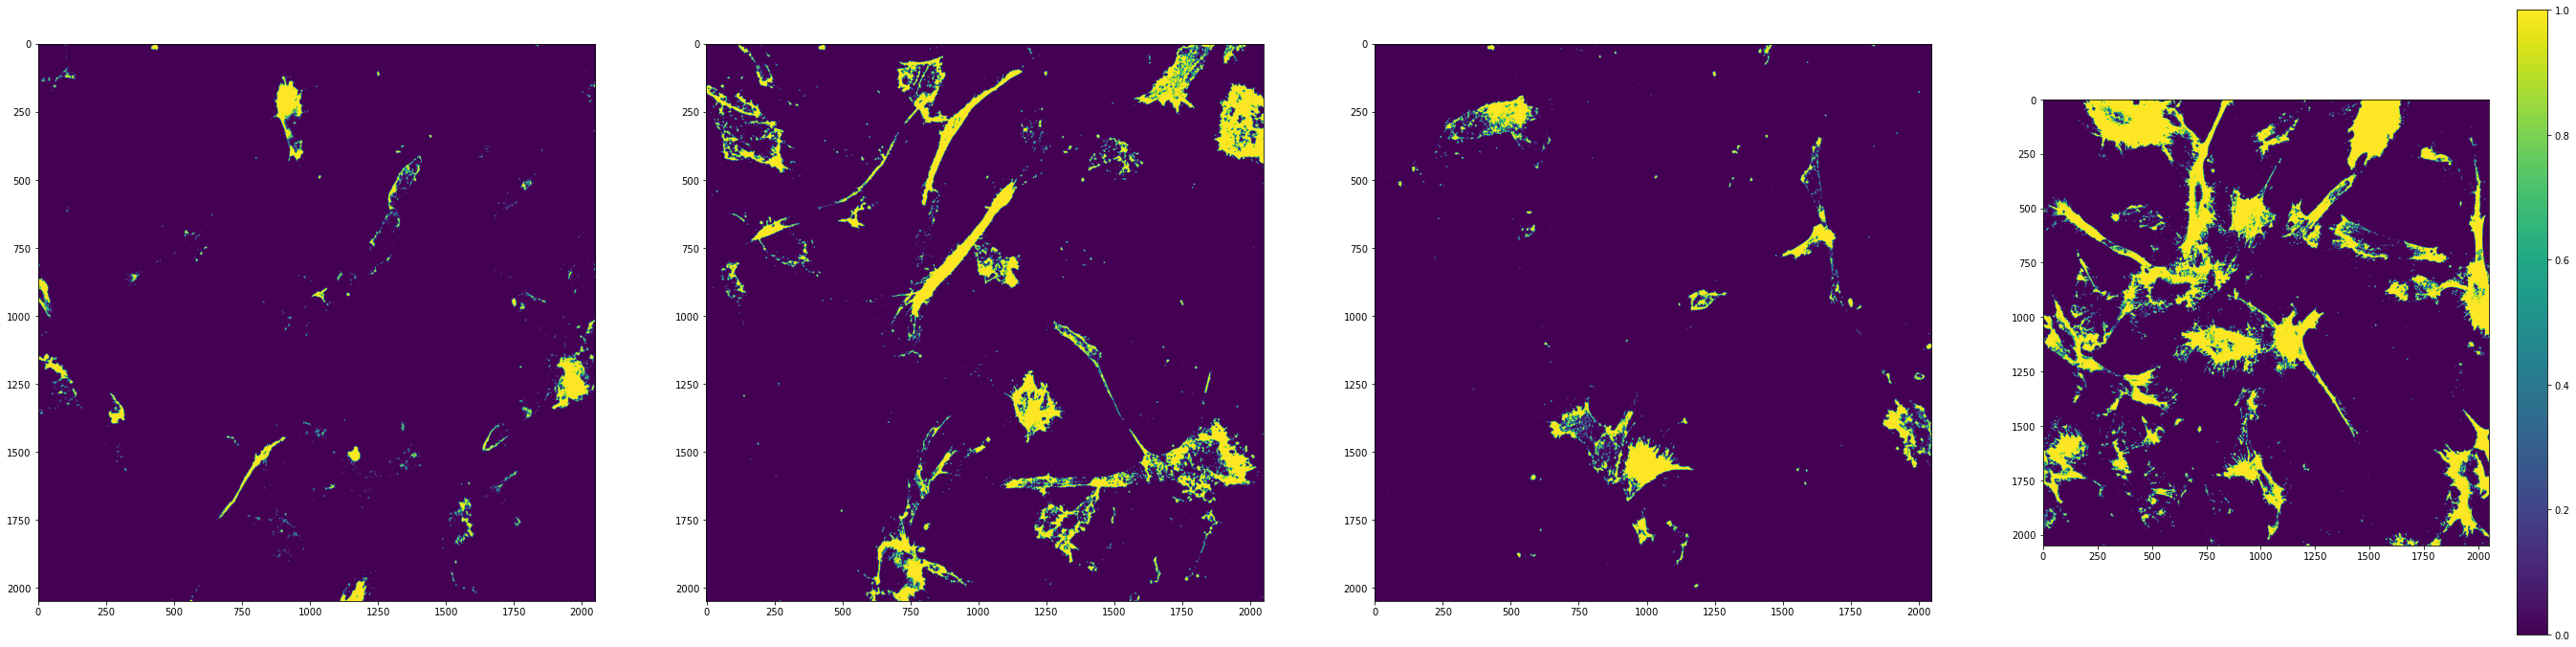

In [14]:
fig, axs = plt.subplots(1,4, figsize=(48,12))
for idx in range(z_identity.shape[0]):
    im = axs[idx].imshow(z_identity[idx])
colorbar = plt.colorbar(im)
plt.show()

## Metrics

In [15]:
# only look at foreground pixels
calculate_metrics(z_identity, z_test)

(2048, 2048) (2048, 2048)
Genotype:  A2
total number of pixels above 0 in identity: 69030
total number of pixels above 0 in test: 13638
percentage of pixels above otsu threshold in identity 1.0
percentage of pixels above otsu threshold in test 1.0
(2048, 2048) (2048, 2048)
Elementwise Accuracy with Deviation:  0.0863763015104854
Mean Squared Error:  0.019147872924804688
Structural Similarity Index:  [0.9294206683968815]


(2048, 2048) (2048, 2048)
Genotype:  E8
total number of pixels above 0 in identity: 302885
total number of pixels above 0 in test: 9587
percentage of pixels above otsu threshold in identity 1.0
percentage of pixels above otsu threshold in test 1.0
(2048, 2048) (2048, 2048)
Elementwise Accuracy with Deviation:  0.9994784604151455
Mean Squared Error:  0.0699300765991211
Structural Similarity Index:  [0.8652421502680692]


(2048, 2048) (2048, 2048)
Genotype:  D11
total number of pixels above 0 in identity: 99796
total number of pixels above 0 in test: 3468
percentage of 

# Testing with Otsu on z_test *before* deconvolution

In [16]:
img = image[4]
# Split img into test image and identity part of image
img_test = img[:3]
print("Shape of our test image:", img_test.shape)
img_identity = img[3:]
print("Shape of our identity image:", img_identity.shape) 

Shape of our test image: (3, 2048, 2048)
Shape of our identity image: (3, 2048, 2048)


In [17]:
 for i in range(img_test.shape[0]):
    img_test[i][img_test[i] < threshold_otsu(img_test[i])] = 0
    img_test[i][img_test[i] > threshold_otsu(img_test[i])] = 1
    img_identity[i][img_identity[i] < threshold_otsu(img_identity[i])] = 0
    img_identity[i][img_identity[i] > threshold_otsu(img_identity[i])] = 1

In [18]:
# Now we perform matching pursuit
z_test = matching_pursuit(img_test, matrix_test.T, max_iters=3)
print("z_test shape:", z_test.shape)
z_identity = np.concatenate([img_identity, np.array([img_test.sum(0) - 2*img_identity.sum(0)])], axis=0)
print("z_identity shape:", z_identity.shape) 

[[1. 1. 0.]
 [0. 1. 1.]
 [1. 0. 1.]
 [1. 1. 1.]]
[[0.70710678 0.70710678 0.        ]
 [0.         0.70710678 0.70710678]
 [0.70710678 0.         0.70710678]
 [0.57735027 0.57735027 0.57735027]]
(4, 3) (3, 2048, 2048)
z_test shape: (4, 2048, 2048)
z_identity shape: (4, 2048, 2048)


## Test After Deconvolution

C:\Users\vinhl\AppData\Local\Temp\ipykernel_17528\1724634805.py:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("tab20").copy()
  cm.set_bad('k')


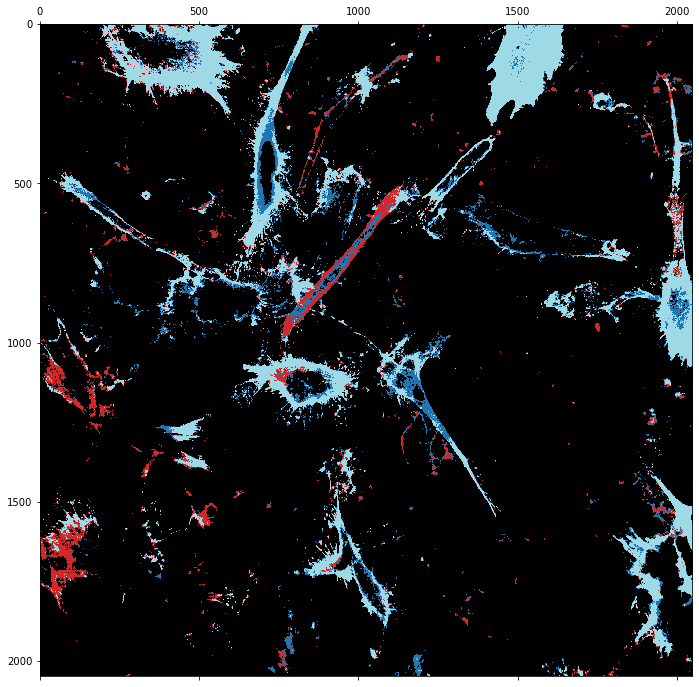

In [19]:
cm = plt.get_cmap('tab20')
cm.set_bad('k')
plt.figure(figsize=(12,12))
plt.gca().matshow(np.where(z_test.max(0)==0,np.nan,z_test.argmax(0)),cmap=cm)

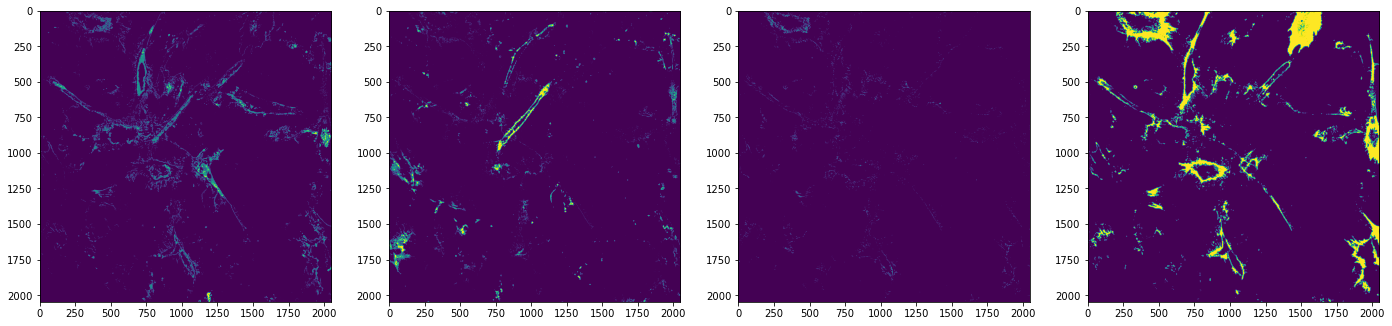

In [20]:
fig, axs = plt.subplots(1,4, figsize=(24,24))
for idx in range(z_test.shape[0]):
    axs[idx].imshow(z_test[idx])
plt.show()

## Identity After Concat

C:\Users\vinhl\AppData\Local\Temp\ipykernel_17528\1283809606.py:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("tab20").copy()
  cm.set_bad('k')


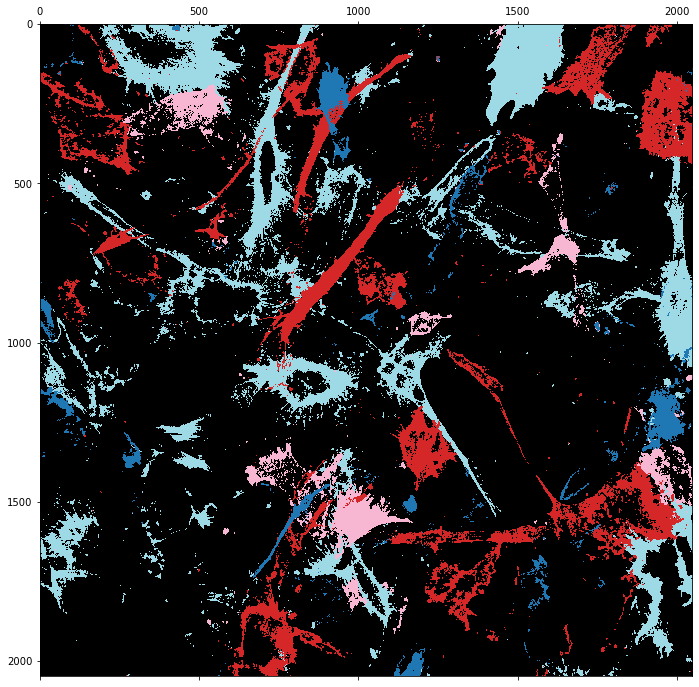

In [21]:
cm = plt.get_cmap('tab20')
cm.set_bad('k')
plt.figure(figsize=(12,12))
plt.gca().matshow(np.where(z_identity.max(0)==0,np.nan,z_identity.argmax(0)),cmap=cm)

(4, 2048, 2048)


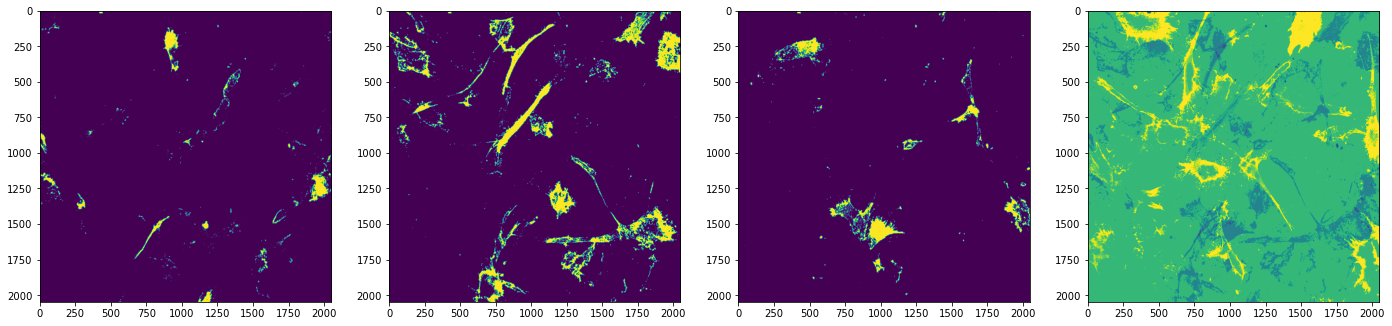

In [24]:
fig, axs = plt.subplots(1,4, figsize=(24,24))
for idx in range(z_identity.shape[0]):
    axs[idx].imshow(z_identity[idx])
plt.show()

## Metrics

In [25]:
calculate_metrics(z_identity, z_test)

(2048, 2048) (2048, 2048)
Genotype:  A2
total number of pixels above 0 in identity: 69030
total number of pixels above 0 in test: 124651
percentage of pixels above otsu threshold in identity 1.0
percentage of pixels above otsu threshold in test 1.0
(2048, 2048) (2048, 2048)
Elementwise Accuracy with Deviation:  0.0
Mean Squared Error:  0.043123106955248326
Structural Similarity Index:  [0.8057456315611012]


(2048, 2048) (2048, 2048)
Genotype:  E8
total number of pixels above 0 in identity: 302885
total number of pixels above 0 in test: 81847
percentage of pixels above otsu threshold in identity 1.0
percentage of pixels above otsu threshold in test 1.0
(2048, 2048) (2048, 2048)
Elementwise Accuracy with Deviation:  0.0
Mean Squared Error:  0.08031920941898887
Structural Similarity Index:  [0.796932630381131]


(2048, 2048) (2048, 2048)
Genotype:  D11
total number of pixels above 0 in identity: 99796
total number of pixels above 0 in test: 12179
percentage of pixels above otsu threshold